## U-Net网络结构参考

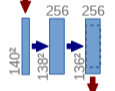
在网络图中两个蓝色箭头（Conv+ReLU两次）

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

## 这里实现连续的两个conv3×3+ReLu

In [2]:
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, padding=0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3,stride=1,padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3,stride=1,padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
 
    def forward(self,x):
        x = self.conv(x)
        return x

（1）由于U-Net的左右特征图需要进行通道上的拼接，所以下面的代码中需要多次使用torch.cat()函数进行拼接  
（2）以left开头的属性表示左边的卷积操作，pool函数表示左边的池化操作  
（3）以right开头的属性表示右边的卷积操作（右边的卷积输入为左边对应位置特征图和前一层特征图的cat结果），de开头表示反卷积

## 下采样
这里的下采样包括max pool下采样和连续的两个conv3×3+ReLu。


In [3]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, padding=0):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            conv_block(in_channels, out_channels, padding=padding)
        )
 
    def forward(self, x):
        return self.maxpool_conv(x)

## 上采样
这里的上采样包括转置卷积上采样，并与左侧对应编码器的特征图拼接（concatenation）。之后进行连续的两个conv3×3+ReLu

In [4]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, concat=0):
        super().__init__()
        """
        concat=0 -> do center crop
        concat=1 -> padding decoder feature map
        concat=2 -> padding=1 in conv_block
        """
        self.concat = concat
        if self.concat not in [0, 1, 2]:
            raise Exception('concat not in list of [0, 1, 2]')
        if self.concat == 2:
            padding = 1
 
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = conv_block(in_channels, out_channels, padding=padding)
 
    def forward(self, x, x_copy):
        x = self.up(x)
 
        if self.concat == 0:
            B, C, H, W = x.shape
            x_copy = torchvision.transforms.CenterCrop([H, W])(x_copy)
            
        elif self.concat == 1:
            diffY = x_copy.size()[2] - x.size()[2]
            diffX = x_copy.size()[3] - x.size()[3]
            x = F.pad(x, [
                diffX // 2, diffX - diffX // 2, 
                diffY // 2, diffY - diffY // 2
                ])
        #按通道维度进行拼接 
        x = torch.cat([x_copy, x], dim=1)
        return self.conv(x)

In [5]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, concat=0):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.concat = concat
 
        if concat == 2:
            padding = 1
        else:
            padding = 0
 
        expansion = 2
        inplanes = 64
        chns = [inplanes, inplanes*expansion, inplanes*expansion**2, inplanes*expansion**3, inplanes*expansion**4]
 
        self.inc = conv_block(n_channels, chns[0], padding)
        self.down1 = DownSample(chns[0], chns[1], padding)
        self.down2 = DownSample(chns[1], chns[2], padding)
        self.down3 = DownSample(chns[2], chns[3], padding)
        self.down4 = DownSample(chns[3], chns[4], padding)
 
        self.up1 = UpSample(chns[-1], chns[-2], concat)
        self.up2 = UpSample(chns[-2], chns[-3], concat)
        self.up3 = UpSample(chns[-3], chns[-4], concat)
        self.up4 = UpSample(chns[-4], chns[-5], concat)
        self.outc = nn.Conv2d(chns[-5], n_classes, kernel_size=1)
 
    def forward(self, x):
        e1 = self.inc(x)
        e2 = self.down1(e1)
        e3 = self.down2(e2)
        e4 = self.down3(e3)
        e5 = self.down4(e4)
        
        x = self.up1(e5, e4)
        x = self.up2(x, e3)
        x = self.up3(x, e2)
        x = self.up4(x, e1)
        logits = self.outc(x)
 
        return logits

https://zhuanlan.zhihu.com/p/87593567

In [6]:
if __name__ == "__main__":
    x = torch.rand(size=(8, 3, 224, 224))
    net =  UNet(3,10,2)
    out = net(x)
    print(out.size())
   #torch.Size([8, 10, 224, 224])

torch.Size([8, 10, 224, 224])
ok


## 查看Unet网络结构

In [7]:
from torchsummary import summary
summary( net,(3,224,224),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
        conv_block-7         [-1, 64, 224, 224]               0
         MaxPool2d-8         [-1, 64, 112, 112]               0
            Conv2d-9        [-1, 128, 112, 112]          73,856
      BatchNorm2d-10        [-1, 128, 112, 112]             256
             ReLU-11        [-1, 128, 112, 112]               0
           Conv2d-12        [-1, 128, 112, 112]         147,584
      BatchNorm2d-13        [-1, 128, 112, 112]             256
             ReLU-14        [-1, 128, 1

https://blog.csdn.net/weixin_42645636/article/details/128574911  


## This is all about implementing UNet from scratch using PyTorch.

https://debuggercafe.com/unet-from-scratch-using-pytorch/  
https://debuggercafe.com/training-unet-from-scratch/  

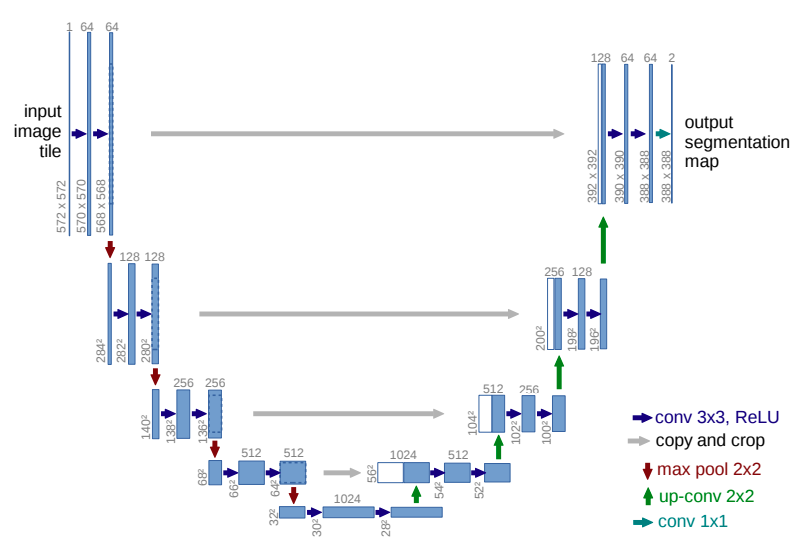

In [12]:
import torch
import torch.nn as nn
def double_convolution(in_channels, out_channels):
    """
    In the original paper implementation, the convolution operations were
    not padded but we are padding them here. This is because, we need the 
    output result size to be same as input size.
    """
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )
    return conv_op

In [13]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # 压缩部分.
        # 每步包含两次卷积.
        self.down_convolution_1 = double_convolution(3, 64)
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        self.down_convolution_5 = double_convolution(512, 1024)
        #扩展部分
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=2, 
            stride=2)
        # 通道数变为1024 as we are concatinating.
        self.up_convolution_1 = double_convolution(1024, 512)
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2, 
            stride=2)
        self.up_convolution_2 = double_convolution(512, 256)
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2, 
            stride=2)
        self.up_convolution_3 = double_convolution(256, 128)
        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2, 
            stride=2)
        self.up_convolution_4 = double_convolution(128, 64)
        # 把类的数量作为输出通道数.
        self.out = nn.Conv2d(
            in_channels=64, out_channels=num_classes, 
            kernel_size=1
        ) 
    def forward(self, x):
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8)        
        # 对down_9 无需进行池化
        
        up_1 = self.up_transpose_1(down_9)
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1))  #横向拼接，要求down_7与up_1相同的行数
        up_2 = self.up_transpose_2(x)
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1))
        up_3 = self.up_transpose_3(x)
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1))
        up_4 = self.up_transpose_4(x)
        x = self.up_convolution_4(torch.cat([down_1, up_4], 1))
        out = self.out(x)
        return out

In [14]:
if __name__ == '__main__':
    input_image = torch.rand((1, 3, 512, 512))
    model = UNet(num_classes=10)
    # Total parameters and trainable parameters.
    total_params = sum(p.numel() for p in model.parameters())
    print(f"{total_params:,} total parameters.")
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{total_trainable_params:,} training parameters.")
    outputs = model(input_image)
    print(outputs.shape)

31,032,330 total parameters.
31,032,330 training parameters.
torch.Size([1, 10, 512, 512])


https://blog.csdn.net/weixin_38346042/article/details/125246551

skip connection （这个就是下采样和上采样得到的相同尺度的特征度在通道维度上的拼接，concatenate）  
原论文中输入输出的高宽并不一致，但是在他人复现过程中，每次卷积都会使用padding来实现Same卷积，使得**输入输出高宽保持一致。**还会加上BN层

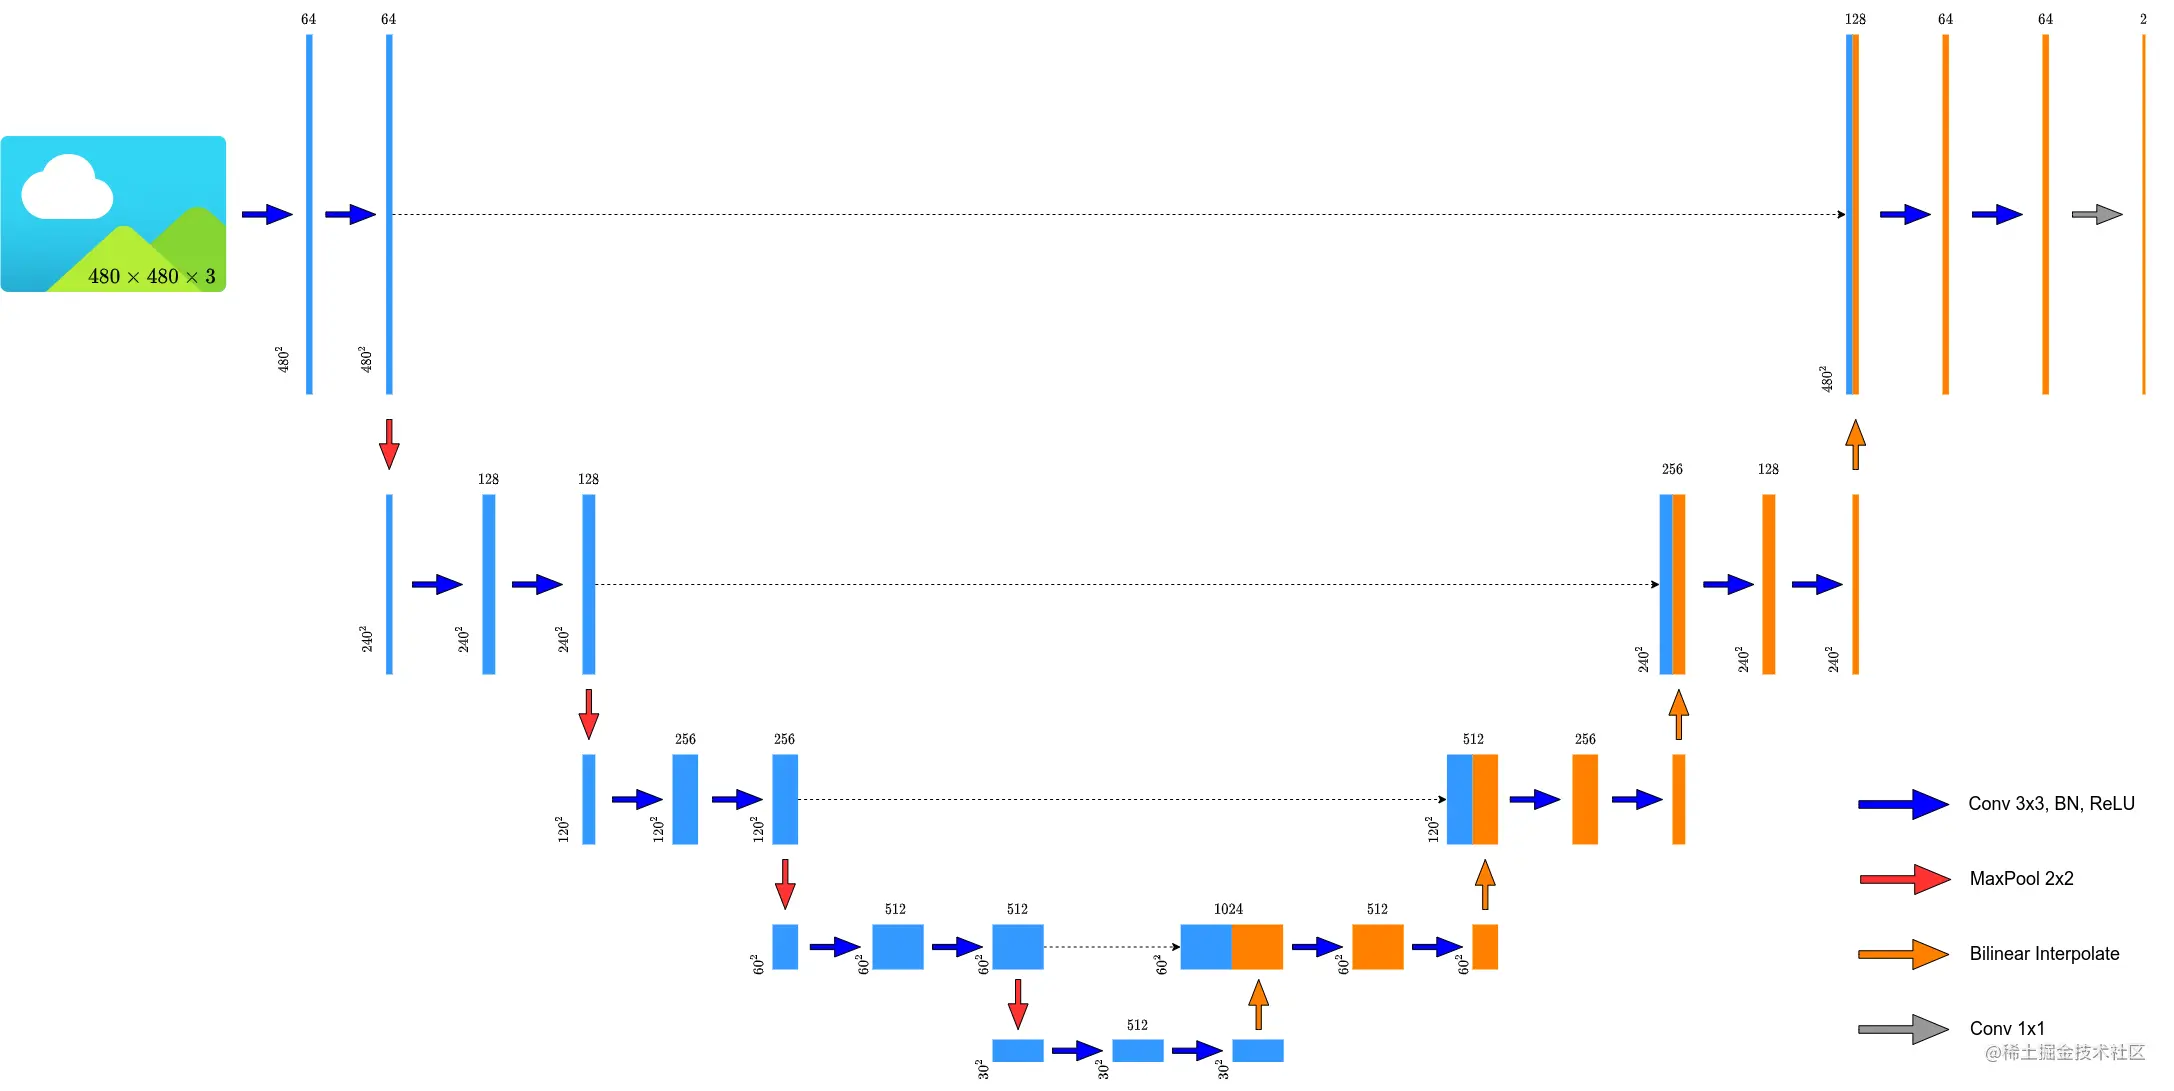